# Librerias

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL
from PIL import Image
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

torch.manual_seed(123)
random.seed(123)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# Dataset

In [2]:
# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((78, 78)),
    transforms.ToTensor(),  # Convertir a tensor de PyTorch
    #transforms.Normalize((0.4915, 0.4823, 0.4468),
                             #(0.2470, 0.2435, 0.2616))
])



# Crear dataset personalizado de PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = ['Under', 'Over', 'Empty', 'OK']
        self.imgs = []
        
        for i, cls in enumerate(self.classes):
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.imgs.append((img_path, i))  # Añadir ruta de imagen y su label
        
        # Mezclar las imágenes antes de dividir el dataset
        random.shuffle(self.imgs)
                
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        return img, label

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Crear el dataset personalizado
dataset = CustomDataset('/content/drive/MyDrive/DatasetTFG/labeled')

In [5]:
#Trabajamos en la GPU
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [6]:
dataset_1 = torch.utils.data.Subset(dataset, range(10000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_1))
val_size = len(dataset_1) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_1, [train_size, val_size])

In [7]:
# Create datasets for training and validation
image_datasets = {'train': train_data, 'val': val_data}

# Create dataloaders for training and validation
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [8]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 11

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,val_loss_history,train_acc_history,train_loss_history

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 314MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

# Puebas de optimizadores con diferentes learning rate

## SGD

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.1, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.8414 Acc: 0.4923
val Loss: 0.8558 Acc: 0.5640

Epoch 1/10
----------
train Loss: 0.8262 Acc: 0.6346
val Loss: 0.6255 Acc: 0.7520

Epoch 2/10
----------
train Loss: 0.6854 Acc: 0.7310
val Loss: 0.5163 Acc: 0.8055

Epoch 3/10
----------
train Loss: 0.6025 Acc: 0.7718
val Loss: 0.5045 Acc: 0.8140

Epoch 4/10
----------
train Loss: 0.5870 Acc: 0.7722
val Loss: 0.5387 Acc: 0.8000

Epoch 5/10
----------
train Loss: 0.5406 Acc: 0.7937
val Loss: 0.5827 Acc: 0.7860

Epoch 6/10
----------
train Loss: 0.5146 Acc: 0.7997
val Loss: 0.4858 Acc: 0.8045

Epoch 7/10
----------
train Loss: 0.5004 Acc: 0.8056
val Loss: 0.4797 Acc: 0.8210

Epoch 8/10
----------
train Loss: 0.4894 Acc: 0.8149
val Loss: 0.4610 Acc: 0.8155

Epoch 9/10
----------
train Loss: 0.4885 Acc: 0.8110
val Loss: 0.5443 Acc: 0.7845

Epoch 10/10
----------
train Loss: 0.4725 Acc: 0.8186
val Loss: 0.4604 Acc: 0.8300

Training complete in 101m 36s
Best val Acc: 0.830000


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.05, momentum=0.9) #Se varia lr

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.8464 Acc: 0.5609
val Loss: 0.6084 Acc: 0.7795

Epoch 1/10
----------
train Loss: 0.6602 Acc: 0.7492
val Loss: 0.6479 Acc: 0.7685

Epoch 2/10
----------
train Loss: 0.5801 Acc: 0.7785
val Loss: 0.4729 Acc: 0.8115

Epoch 3/10
----------
train Loss: 0.5405 Acc: 0.7914
val Loss: 0.4503 Acc: 0.8315

Epoch 4/10
----------
train Loss: 0.4967 Acc: 0.8120
val Loss: 0.4856 Acc: 0.8280

Epoch 5/10
----------
train Loss: 0.4850 Acc: 0.8164
val Loss: 0.4585 Acc: 0.8285

Epoch 6/10
----------
train Loss: 0.4589 Acc: 0.8211
val Loss: 0.4950 Acc: 0.8100

Epoch 7/10
----------
train Loss: 0.4501 Acc: 0.8276
val Loss: 0.4707 Acc: 0.8230

Epoch 8/10
----------
train Loss: 0.4324 Acc: 0.8373
val Loss: 0.4410 Acc: 0.8275

Epoch 9/10
----------
train Loss: 0.4285 Acc: 0.8321
val Loss: 0.4749 Acc: 0.8115

Epoch 10/10
----------
train Loss: 0.4184 Acc: 0.8371
val Loss: 0.4360 Acc: 0.8280

Training complete in 131m 16s
Best val Acc: 0.831500


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.005, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.1449 Acc: 0.6865
val Loss: 0.5671 Acc: 0.7925

Epoch 1/10
----------
train Loss: 0.7278 Acc: 0.7738
val Loss: 0.4801 Acc: 0.8290

Epoch 2/10
----------
train Loss: 0.6613 Acc: 0.7792
val Loss: 0.4441 Acc: 0.8205

Epoch 3/10
----------
train Loss: 0.5551 Acc: 0.8045
val Loss: 0.4714 Acc: 0.8195

Epoch 4/10
----------
train Loss: 0.5283 Acc: 0.8156
val Loss: 0.4391 Acc: 0.8250

Epoch 5/10
----------
train Loss: 0.4772 Acc: 0.8309
val Loss: 0.4420 Acc: 0.8265

Epoch 6/10
----------
train Loss: 0.4396 Acc: 0.8335
val Loss: 0.4564 Acc: 0.8235

Epoch 7/10
----------
train Loss: 0.4365 Acc: 0.8379
val Loss: 0.5509 Acc: 0.7960

Epoch 8/10
----------
train Loss: 0.4121 Acc: 0.8471
val Loss: 0.4275 Acc: 0.8340

Epoch 9/10
----------
train Loss: 0.3856 Acc: 0.8588
val Loss: 0.4772 Acc: 0.8085

Epoch 10/10
----------
train Loss: 0.3502 Acc: 0.8678
val Loss: 0.4684 Acc: 0.8225

Training complete in 20m 43s
Best val Acc: 0.834000


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6211 Acc: 0.7538
val Loss: 0.4824 Acc: 0.8155

Epoch 1/10
----------
train Loss: 0.4868 Acc: 0.8110
val Loss: 0.4675 Acc: 0.8200

Epoch 2/10
----------
train Loss: 0.4205 Acc: 0.8376
val Loss: 0.5019 Acc: 0.8170

Epoch 3/10
----------
train Loss: 0.3699 Acc: 0.8624
val Loss: 0.5129 Acc: 0.8210

Epoch 4/10
----------
train Loss: 0.3214 Acc: 0.8751
val Loss: 0.5425 Acc: 0.8170

Epoch 5/10
----------
train Loss: 0.2841 Acc: 0.8970
val Loss: 0.5651 Acc: 0.8110

Epoch 6/10
----------
train Loss: 0.2457 Acc: 0.9093
val Loss: 0.6185 Acc: 0.8075

Epoch 7/10
----------
train Loss: 0.2165 Acc: 0.9236
val Loss: 0.6765 Acc: 0.8080

Epoch 8/10
----------
train Loss: 0.1689 Acc: 0.9387
val Loss: 0.6896 Acc: 0.8080

Epoch 9/10
----------
train Loss: 0.1765 Acc: 0.9385
val Loss: 0.6633 Acc: 0.8170

Epoch 10/10
----------
train Loss: 0.1216 Acc: 0.9593
val Loss: 0.6958 Acc: 0.8185

Training complete in 19m 41s
Best val Acc: 0.821000


### Representaciones

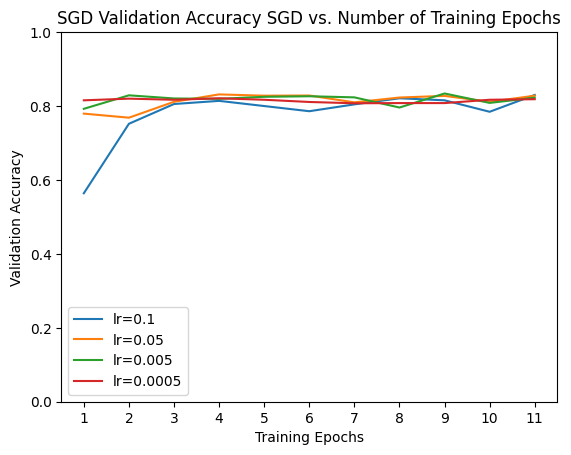

In [8]:
# Se grafican los valores historicos de precisión de validacion en scratch y preentrenado
hist_val_acc_1 = [0.5640, 0.7520, 0.8055, 0.8140, 0.8000, 0.7860, 0.8045, 0.8210, 0.8155, 0.7845, 0.8300]
hist_val_acc_2 = [0.7795, 0.7685, 0.8115, 0.8315, 0.8280, 0.8285, 0.8100, 0.8230, 0.8275, 0.8115, 0.8280]
hist_val_acc_3 = [0.7925, 0.8290, 0.8205, 0.8195, 0.8250, 0.8265, 0.8235, 0.7960, 0.8340, 0.8085, 0.8225]
hist_val_acc_4 = [0.8155, 0.8200, 0.8170, 0.8210, 0.8170, 0.8110, 0.8075, 0.8080, 0.8080, 0.8170, 0.8185]

plt.title("SGD Validation Accuracy SGD vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_val_acc_1,label="lr=0.1")
plt.plot(range(1,num_epochs+1),hist_val_acc_2,label="lr=0.05")
plt.plot(range(1,num_epochs+1),hist_val_acc_3,label="lr=0.005")
plt.plot(range(1,num_epochs+1),hist_val_acc_4,label="lr=0.0005")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Adam

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.1) #Igual para Adagrad y Adadelta

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.5109 Acc: 0.5677
val Loss: 0.8432 Acc: 0.6760

Epoch 1/10
----------
train Loss: 0.6633 Acc: 0.7489
val Loss: 0.6429 Acc: 0.7345

Epoch 2/10
----------
train Loss: 0.6266 Acc: 0.7680
val Loss: 0.5732 Acc: 0.7885

Epoch 3/10
----------
train Loss: 0.6005 Acc: 0.7766
val Loss: 0.5066 Acc: 0.8195

Epoch 4/10
----------
train Loss: 0.5603 Acc: 0.7901
val Loss: 0.4933 Acc: 0.8020

Epoch 5/10
----------
train Loss: 0.5299 Acc: 0.7945
val Loss: 0.6108 Acc: 0.7550

Epoch 6/10
----------
train Loss: 0.5234 Acc: 0.8029
val Loss: 0.5172 Acc: 0.7950

Epoch 7/10
----------
train Loss: 0.5194 Acc: 0.8050
val Loss: 0.4639 Acc: 0.8230

Epoch 8/10
----------
train Loss: 0.5207 Acc: 0.8044
val Loss: 0.5127 Acc: 0.7930

Epoch 9/10
----------
train Loss: 0.5267 Acc: 0.8031
val Loss: 0.4840 Acc: 0.8060

Epoch 10/10
----------
train Loss: 0.4974 Acc: 0.8149
val Loss: 0.4641 Acc: 0.8405

Training complete in 31m 49s
Best val Acc: 0.840500


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.05)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.0999 Acc: 0.6745
val Loss: 0.5851 Acc: 0.7950

Epoch 1/10
----------
train Loss: 0.6141 Acc: 0.7701
val Loss: 0.5446 Acc: 0.7940

Epoch 2/10
----------
train Loss: 0.5511 Acc: 0.7885
val Loss: 0.4870 Acc: 0.8170

Epoch 3/10
----------
train Loss: 0.5006 Acc: 0.8069
val Loss: 0.4826 Acc: 0.8245

Epoch 4/10
----------
train Loss: 0.4938 Acc: 0.8157
val Loss: 0.4720 Acc: 0.8095

Epoch 5/10
----------
train Loss: 0.4883 Acc: 0.8187
val Loss: 0.4886 Acc: 0.8150

Epoch 6/10
----------
train Loss: 0.4635 Acc: 0.8229
val Loss: 0.4812 Acc: 0.8065

Epoch 7/10
----------
train Loss: 0.4581 Acc: 0.8266
val Loss: 0.4553 Acc: 0.8270

Epoch 8/10
----------
train Loss: 0.4479 Acc: 0.8305
val Loss: 0.4707 Acc: 0.8180

Epoch 9/10
----------
train Loss: 0.4466 Acc: 0.8265
val Loss: 0.4541 Acc: 0.8200

Epoch 10/10
----------
train Loss: 0.4338 Acc: 0.8335
val Loss: 0.4333 Acc: 0.8305

Training complete in 70m 40s
Best val Acc: 0.830500


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.005)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.9198 Acc: 0.6432
val Loss: 0.5702 Acc: 0.8050

Epoch 1/10
----------
train Loss: 0.5936 Acc: 0.7760
val Loss: 0.5028 Acc: 0.8050

Epoch 2/10
----------
train Loss: 0.5391 Acc: 0.7930
val Loss: 0.4427 Acc: 0.8260

Epoch 3/10
----------
train Loss: 0.4840 Acc: 0.8140
val Loss: 0.4621 Acc: 0.8255

Epoch 4/10
----------
train Loss: 0.4493 Acc: 0.8265
val Loss: 0.5454 Acc: 0.7975

Epoch 5/10
----------
train Loss: 0.4365 Acc: 0.8339
val Loss: 0.4399 Acc: 0.8245

Epoch 6/10
----------
train Loss: 0.4272 Acc: 0.8304
val Loss: 0.4802 Acc: 0.8035

Epoch 7/10
----------
train Loss: 0.4146 Acc: 0.8401
val Loss: 0.4286 Acc: 0.8270

Epoch 8/10
----------
train Loss: 0.4021 Acc: 0.8429
val Loss: 0.4200 Acc: 0.8310

Epoch 9/10
----------
train Loss: 0.3907 Acc: 0.8463
val Loss: 0.4746 Acc: 0.8180

Epoch 10/10
----------
train Loss: 0.3764 Acc: 0.8511
val Loss: 0.4424 Acc: 0.8285

Training complete in 68m 10s
Best val Acc: 0.831000


### Representaciones

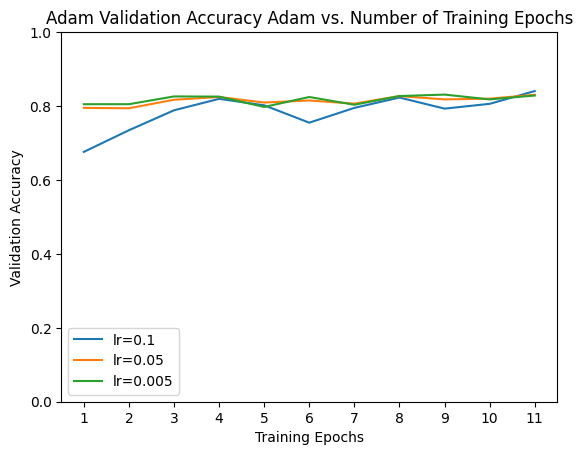

In [7]:
# Se grafican los valores historicos de precisión de validacion en scratch y preentrenado
hist_val_acc_1 = [0.6760, 0.7345, 0.7885, 0.8195, 0.8020,  0.7550, 0.7950, 0.8230, 0.7930, 0.8060, 0.8405]
hist_val_acc_2 = [0.7950, 0.7940, 0.8170, 0.8245, 0.8095,  0.8150, 0.8065, 0.8270, 0.8180, 0.8200, 0.8305]
hist_val_acc_3 = [0.8050, 0.8050, 0.8260, 0.8255, 0.7975, 0.8245, 0.8035, 0.8270, 0.8310, 0.8180, 0.8285]

plt.title("Adam Validation Accuracy Adam vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_val_acc_1,label="lr=0.1")
plt.plot(range(1,num_epochs+1),hist_val_acc_2,label="lr=0.05")
plt.plot(range(1,num_epochs+1),hist_val_acc_3,label="lr=0.005")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Adagrad

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adagrad(params_to_update, lr=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.2156 Acc: 0.6318
val Loss: 1.4894 Acc: 0.7375

Epoch 1/10
----------
train Loss: 0.6439 Acc: 0.7535
val Loss: 1.0324 Acc: 0.7365

Epoch 2/10
----------
train Loss: 0.6159 Acc: 0.7570
val Loss: 0.4783 Acc: 0.8265

Epoch 3/10
----------
train Loss: 0.5267 Acc: 0.7983
val Loss: 3.2421 Acc: 0.6845

Epoch 4/10
----------
train Loss: 0.4723 Acc: 0.8174
val Loss: 0.4522 Acc: 0.8255

Epoch 5/10
----------
train Loss: 0.4497 Acc: 0.8310
val Loss: 0.4980 Acc: 0.7850

Epoch 6/10
----------
train Loss: 0.4328 Acc: 0.8291
val Loss: 0.4872 Acc: 0.8025

Epoch 7/10
----------
train Loss: 0.4149 Acc: 0.8417
val Loss: 1.1819 Acc: 0.7100

Epoch 8/10
----------
train Loss: 0.4039 Acc: 0.8434
val Loss: 0.4339 Acc: 0.8260

Epoch 9/10
----------
train Loss: 0.3995 Acc: 0.8471
val Loss: 0.4274 Acc: 0.8310

Epoch 10/10
----------
train Loss: 0.3847 Acc: 0.8486
val Loss: 0.4262 Acc: 0.8310

Training complete in 30m 57s
Best val Acc: 0.831000


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adagrad(params_to_update, lr=0.05)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.9949 Acc: 0.6192
val Loss: 0.7183 Acc: 0.7335

Epoch 1/10
----------
train Loss: 0.6090 Acc: 0.7626
val Loss: 1.1271 Acc: 0.7320

Epoch 2/10
----------
train Loss: 0.5436 Acc: 0.7890
val Loss: 1.3137 Acc: 0.7605

Epoch 3/10
----------
train Loss: 0.4977 Acc: 0.8096
val Loss: 2.1353 Acc: 0.7460

Epoch 4/10
----------
train Loss: 0.4629 Acc: 0.8205
val Loss: 1.3626 Acc: 0.7505

Epoch 5/10
----------
train Loss: 0.4467 Acc: 0.8325
val Loss: 1.6110 Acc: 0.7590

Epoch 6/10
----------
train Loss: 0.4328 Acc: 0.8323
val Loss: 1.2382 Acc: 0.7395

Epoch 7/10
----------
train Loss: 0.4187 Acc: 0.8405
val Loss: 1.7726 Acc: 0.7575

Epoch 8/10
----------
train Loss: 0.4115 Acc: 0.8411
val Loss: 0.4175 Acc: 0.8330

Epoch 9/10
----------
train Loss: 0.3981 Acc: 0.8431
val Loss: 1.2001 Acc: 0.7575

Epoch 10/10
----------
train Loss: 0.3890 Acc: 0.8476
val Loss: 0.4599 Acc: 0.8290

Training complete in 51m 25s
Best val Acc: 0.833000


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adagrad(params_to_update, lr=0.005)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6590 Acc: 0.7539
val Loss: 0.4675 Acc: 0.8225

Epoch 1/10
----------
train Loss: 0.4864 Acc: 0.8130
val Loss: 0.4335 Acc: 0.8345

Epoch 2/10
----------
train Loss: 0.4320 Acc: 0.8390
val Loss: 0.4244 Acc: 0.8320

Epoch 3/10
----------
train Loss: 0.3847 Acc: 0.8544
val Loss: 0.4690 Acc: 0.8240

Epoch 4/10
----------
train Loss: 0.3338 Acc: 0.8726
val Loss: 0.5299 Acc: 0.8065

Epoch 5/10
----------
train Loss: 0.2889 Acc: 0.8948
val Loss: 0.4723 Acc: 0.8220

Epoch 6/10
----------
train Loss: 0.2288 Acc: 0.9121
val Loss: 0.6253 Acc: 0.7710

Epoch 7/10
----------
train Loss: 0.1791 Acc: 0.9395
val Loss: 0.6189 Acc: 0.8155

Epoch 8/10
----------
train Loss: 0.1354 Acc: 0.9539
val Loss: 0.6271 Acc: 0.7995

Epoch 9/10
----------
train Loss: 0.1130 Acc: 0.9651
val Loss: 0.6592 Acc: 0.8110

Epoch 10/10
----------
train Loss: 0.0651 Acc: 0.9813
val Loss: 0.7525 Acc: 0.8075

Training complete in 52m 42s
Best val Acc: 0.834500


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adagrad(params_to_update, lr=0.0005)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.5627 Acc: 0.7760
val Loss: 0.4777 Acc: 0.8040

Epoch 1/10
----------
train Loss: 0.4108 Acc: 0.8413
val Loss: 0.4735 Acc: 0.8155

Epoch 2/10
----------
train Loss: 0.3612 Acc: 0.8635
val Loss: 0.4785 Acc: 0.8080

Epoch 3/10
----------
train Loss: 0.3218 Acc: 0.8800
val Loss: 0.4859 Acc: 0.8140

Epoch 4/10
----------
train Loss: 0.2780 Acc: 0.8996
val Loss: 0.4992 Acc: 0.8100

Epoch 5/10
----------
train Loss: 0.2539 Acc: 0.9113
val Loss: 0.5263 Acc: 0.8070

Epoch 6/10
----------
train Loss: 0.2347 Acc: 0.9213
val Loss: 0.5535 Acc: 0.8010

Epoch 7/10
----------
train Loss: 0.2076 Acc: 0.9291
val Loss: 0.5532 Acc: 0.8075

Epoch 8/10
----------
train Loss: 0.1863 Acc: 0.9383
val Loss: 0.5681 Acc: 0.8015

Epoch 9/10
----------
train Loss: 0.1774 Acc: 0.9419
val Loss: 0.5897 Acc: 0.7970

Epoch 10/10
----------
train Loss: 0.1445 Acc: 0.9576
val Loss: 0.5975 Acc: 0.7990

Training complete in 21m 37s
Best val Acc: 0.815500


### Representaciones

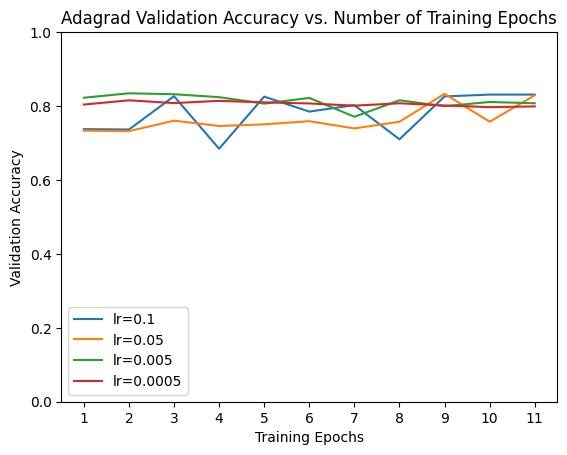

In [9]:
# Se grafican los valores historicos de precisión de validacion en scratch y preentrenado
hist_val_acc_1 = [0.7375, 0.7365, 0.8265, 0.6845, 0.8255, 0.7850, 0.8025, 0.7100, 0.8260, 0.8310, 0.8310]
hist_val_acc_2 = [0.7335, 0.7320, 0.7605, 0.7460, 0.7505, 0.7590, 0.7395, 0.7575, 0.8330, 0.7575, 0.8290]
hist_val_acc_3 = [0.8225, 0.8345, 0.8320, 0.8240, 0.8065, 0.8220, 0.7710, 0.8155, 0.7995, 0.8110, 0.8075]
hist_val_acc_4 = [0.8040, 0.8155, 0.8080, 0.8140, 0.8100, 0.8070, 0.8010, 0.8075, 0.8015, 0.7970, 0.7990]

plt.title("Adagrad Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_val_acc_1,label="lr=0.1")
plt.plot(range(1,num_epochs+1),hist_val_acc_2,label="lr=0.05")
plt.plot(range(1,num_epochs+1),hist_val_acc_3,label="lr=0.005")
plt.plot(range(1,num_epochs+1),hist_val_acc_4,label="lr=0.0005")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Adadelta

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adadelta(params_to_update, lr=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6197 Acc: 0.7630
val Loss: 0.4719 Acc: 0.8210

Epoch 1/10
----------
train Loss: 0.4696 Acc: 0.8226
val Loss: 0.4888 Acc: 0.8320

Epoch 2/10
----------
train Loss: 0.4111 Acc: 0.8424
val Loss: 0.4886 Acc: 0.8305

Epoch 3/10
----------
train Loss: 0.3591 Acc: 0.8674
val Loss: 0.5082 Acc: 0.8190

Epoch 4/10
----------
train Loss: 0.2964 Acc: 0.8921
val Loss: 0.5827 Acc: 0.8235

Epoch 5/10
----------
train Loss: 0.2438 Acc: 0.9126
val Loss: 0.5742 Acc: 0.8210

Epoch 6/10
----------
train Loss: 0.1836 Acc: 0.9361
val Loss: 0.7051 Acc: 0.8105

Epoch 7/10
----------
train Loss: 0.1443 Acc: 0.9553
val Loss: 0.7711 Acc: 0.8265

Epoch 8/10
----------
train Loss: 0.1027 Acc: 0.9675
val Loss: 0.8878 Acc: 0.8105

Epoch 9/10
----------
train Loss: 0.0925 Acc: 0.9731
val Loss: 1.0508 Acc: 0.8105

Epoch 10/10
----------
train Loss: 0.0652 Acc: 0.9798
val Loss: 1.0097 Acc: 0.8155

Training complete in 51m 24s
Best val Acc: 0.832000


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adadelta(params_to_update, lr=0.05)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.5850 Acc: 0.7758
val Loss: 0.4881 Acc: 0.8220

Epoch 1/10
----------
train Loss: 0.4499 Acc: 0.8246
val Loss: 0.5167 Acc: 0.8330

Epoch 2/10
----------
train Loss: 0.3960 Acc: 0.8484
val Loss: 0.5561 Acc: 0.8275

Epoch 3/10
----------
train Loss: 0.3249 Acc: 0.8838
val Loss: 0.5504 Acc: 0.8185

Epoch 4/10
----------
train Loss: 0.2631 Acc: 0.9034
val Loss: 0.7173 Acc: 0.8100

Epoch 5/10
----------
train Loss: 0.2081 Acc: 0.9258
val Loss: 0.7039 Acc: 0.8115

Epoch 6/10
----------
train Loss: 0.1702 Acc: 0.9433
val Loss: 0.8323 Acc: 0.8125

Epoch 7/10
----------
train Loss: 0.1316 Acc: 0.9575
val Loss: 0.8543 Acc: 0.8225

Epoch 8/10
----------
train Loss: 0.0925 Acc: 0.9705
val Loss: 0.9176 Acc: 0.8070

Epoch 9/10
----------
train Loss: 0.0855 Acc: 0.9760
val Loss: 0.9825 Acc: 0.8125

Epoch 10/10
----------
train Loss: 0.0703 Acc: 0.9784
val Loss: 1.0193 Acc: 0.8090

Training complete in 32m 2s
Best val Acc: 0.833000


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adadelta(params_to_update, lr=0.005)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 0.6630 Acc: 0.7364
val Loss: 0.5087 Acc: 0.7885

Epoch 1/10
----------
train Loss: 0.4959 Acc: 0.8051
val Loss: 0.4664 Acc: 0.8120

Epoch 2/10
----------
train Loss: 0.4497 Acc: 0.8260
val Loss: 0.4703 Acc: 0.8055

Epoch 3/10
----------
train Loss: 0.4005 Acc: 0.8449
val Loss: 0.4849 Acc: 0.8100

Epoch 4/10
----------
train Loss: 0.3576 Acc: 0.8604
val Loss: 0.4856 Acc: 0.8065

Epoch 5/10
----------
train Loss: 0.3320 Acc: 0.8754
val Loss: 0.4948 Acc: 0.8135

Epoch 6/10
----------
train Loss: 0.3033 Acc: 0.8880
val Loss: 0.5327 Acc: 0.8030

Epoch 7/10
----------
train Loss: 0.2754 Acc: 0.8995
val Loss: 0.5282 Acc: 0.8145

Epoch 8/10
----------
train Loss: 0.2420 Acc: 0.9111
val Loss: 0.5641 Acc: 0.8100

Epoch 9/10
----------
train Loss: 0.2222 Acc: 0.9208
val Loss: 0.5764 Acc: 0.8115

Epoch 10/10
----------
train Loss: 0.1864 Acc: 0.9357
val Loss: 0.6084 Acc: 0.8005

Training complete in 66m 31s
Best val Acc: 0.814500


In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adadelta(params_to_update, lr=10)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.0084 Acc: 0.6164
val Loss: 0.5029 Acc: 0.8200

Epoch 1/10
----------
train Loss: 0.5950 Acc: 0.7718
val Loss: 0.5061 Acc: 0.8055

Epoch 2/10
----------
train Loss: 0.5385 Acc: 0.7950
val Loss: 0.4428 Acc: 0.8245

Epoch 3/10
----------
train Loss: 0.5026 Acc: 0.8081
val Loss: 0.4478 Acc: 0.8280

Epoch 4/10
----------
train Loss: 0.4791 Acc: 0.8144
val Loss: 0.4612 Acc: 0.8210

Epoch 5/10
----------
train Loss: 0.4662 Acc: 0.8226
val Loss: 0.4690 Acc: 0.8205

Epoch 6/10
----------
train Loss: 0.4520 Acc: 0.8266
val Loss: 0.5642 Acc: 0.7825

Epoch 7/10
----------
train Loss: 0.4468 Acc: 0.8271
val Loss: 0.4810 Acc: 0.8105

Epoch 8/10
----------
train Loss: 0.4430 Acc: 0.8294
val Loss: 0.4584 Acc: 0.8125

Epoch 9/10
----------
train Loss: 0.4330 Acc: 0.8335
val Loss: 0.4844 Acc: 0.8075

Epoch 10/10
----------
train Loss: 0.4306 Acc: 0.8361
val Loss: 0.4475 Acc: 0.8250

Training complete in 67m 41s
Best val Acc: 0.828000


### Representaciones

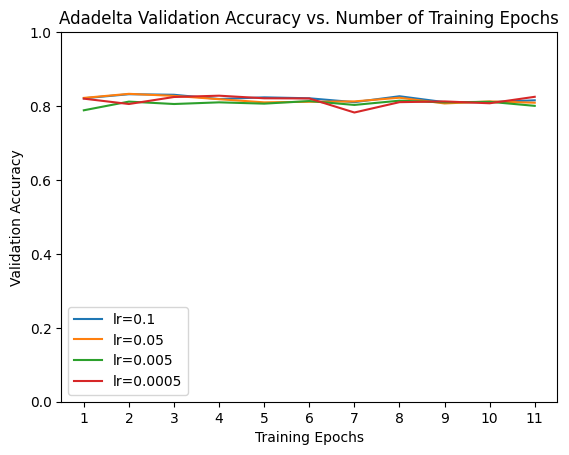

In [10]:
# Se grafican los valores historicos de precisión de validacion en scratch y preentrenado
hist_val_acc_1 = [0.8210, 0.8320, 0.8305, 0.8190, 0.8235, 0.8210, 0.8105, 0.8265, 0.8105, 0.8105, 0.8155]
hist_val_acc_2 = [0.8220, 0.8330, 0.8275, 0.8185, 0.8100, 0.8115, 0.8125, 0.8225, 0.8070, 0.8125, 0.8090 ]
hist_val_acc_3 = [0.7885, 0.8120, 0.8055, 0.8100, 0.8065, 0.8135, 0.8030, 0.8145, 0.8100, 0.8115, 0.8005]
hist_val_acc_4 = [0.8200, 0.8055, 0.8245, 0.8280, 0.8210, 0.8205, 0.7825, 0.8105, 0.8125, 0.8075, 0.8250]

plt.title("Adadelta Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_val_acc_1,label="lr=0.1")
plt.plot(range(1,num_epochs+1),hist_val_acc_2,label="lr=0.05")
plt.plot(range(1,num_epochs+1),hist_val_acc_3,label="lr=0.005")
plt.plot(range(1,num_epochs+1),hist_val_acc_4,label="lr=0.0005")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# Mejores resultados

In [13]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.1) #Igual para Adagrad y Adadelta

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
train Loss: 1.4326 Acc: 0.6321
val Loss: 0.6980 Acc: 0.7835

Epoch 1/10
----------
train Loss: 0.6855 Acc: 0.7341
val Loss: 0.6314 Acc: 0.7650

Epoch 2/10
----------
train Loss: 0.6401 Acc: 0.7589
val Loss: 0.5421 Acc: 0.8040

Epoch 3/10
----------
train Loss: 0.5790 Acc: 0.7870
val Loss: 0.5241 Acc: 0.8200

Epoch 4/10
----------
train Loss: 0.5771 Acc: 0.7856
val Loss: 0.4751 Acc: 0.8200

Epoch 5/10
----------
train Loss: 0.5424 Acc: 0.7981
val Loss: 0.6771 Acc: 0.7455

Epoch 6/10
----------
train Loss: 0.5295 Acc: 0.7984
val Loss: 0.5087 Acc: 0.7940

Epoch 7/10
----------
train Loss: 0.5349 Acc: 0.8015
val Loss: 0.4742 Acc: 0.8280

Epoch 8/10
----------
train Loss: 0.5227 Acc: 0.8034
val Loss: 0.4949 Acc: 0.8055

Epoch 9/10
----------
train Loss: 0.5427 Acc: 0.7946
val Loss: 0.4774 Acc: 0.8230

Epoch 10/10
----------
train Loss: 0.5063 Acc: 0.8067
val Loss: 0.4626 Acc: 0.8260

Training complete in 32m 10s
Best val Acc: 0.828000


In [14]:
#Se importan las librerias necesarias para las representaciones graficas complejas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

In [15]:
#Se definen las clases del dataset
classes = ('Under', 'Over', 'Empty', 'OK')

In [16]:
#En entas líneas de guardan los valores reales y supuestos del dataset y los resultados para las representaciones
y_pred_val = []
y_true_val = []
yscore_val = []

for inputs, labels in dataloaders_dict['val']: #validación o entrenamiento
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_val.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_val.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_val.extend(yscore)

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
yscore_val = np.array(yscore_val)

In [17]:
y_pred_train = []
y_true_train = []
yscore_train = []

for inputs, labels in dataloaders_dict['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_train.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_train.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_train.extend(yscore)

y_pred_train = np.array(y_pred_train)
y_true_train = np.array(y_true_train)
yscore_train = np.array(yscore_train)

In [18]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_true_train)
y_onehot_test = label_binarizer.transform(y_true_val)
y_onehot_test.shape  # (n_samples, n_classes)

(2000, 4)

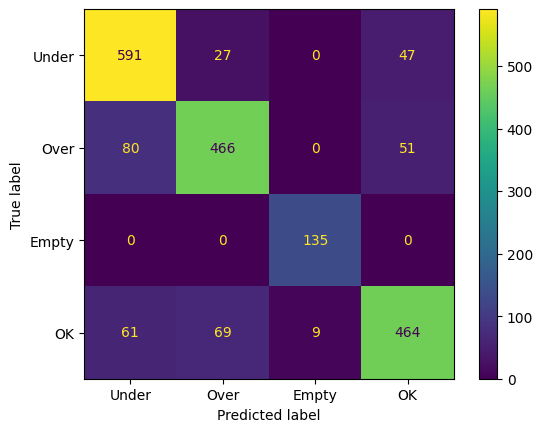

In [19]:
# Mostrar matriz de confusion
cf_matrix = confusion_matrix(y_true_val, y_pred_val) #Validacion o entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()

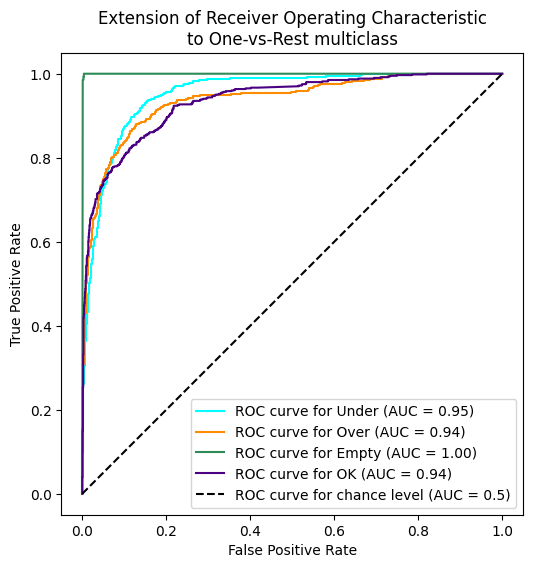

In [20]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

colors = cycle(["aqua", "darkorange", "seagreen","indigo"])
for class_id, color in zip(range(len(classes)), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        yscore_val[:, class_id],
        name=f"ROC curve for {classes[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [21]:
class_dict = {0: 'Under', 1: 'Over', 2: 'Empty', 3: 'Ok'}
y_true_valnames = [(class_dict[label])
          for label in y_true_val
          if label in [0, 1, 2, 3]]

In [22]:
from itertools import combinations


pair_list = list(combinations(np.unique(y_true_val), 2))
print(pair_list)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


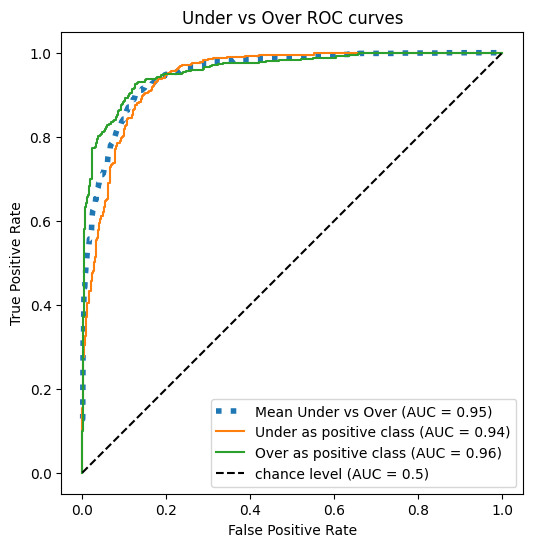

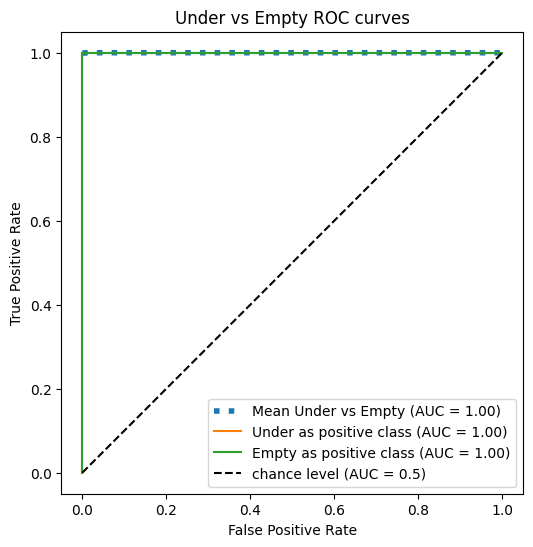

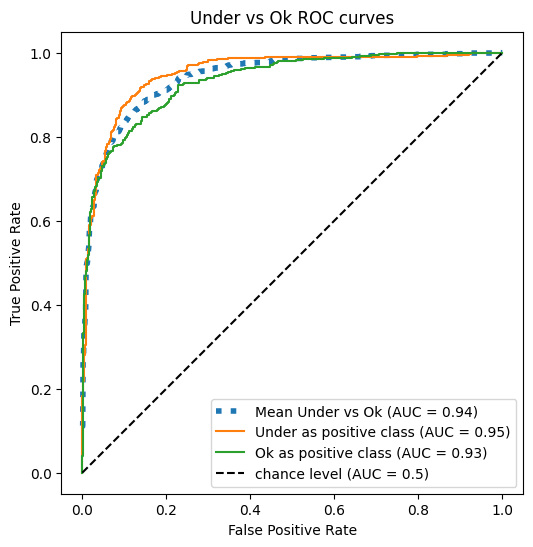

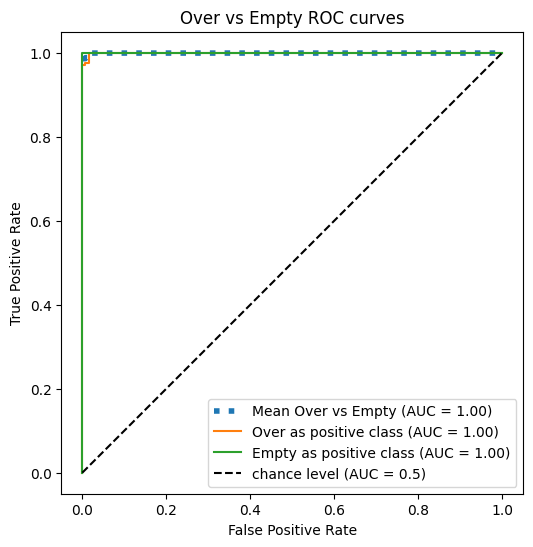

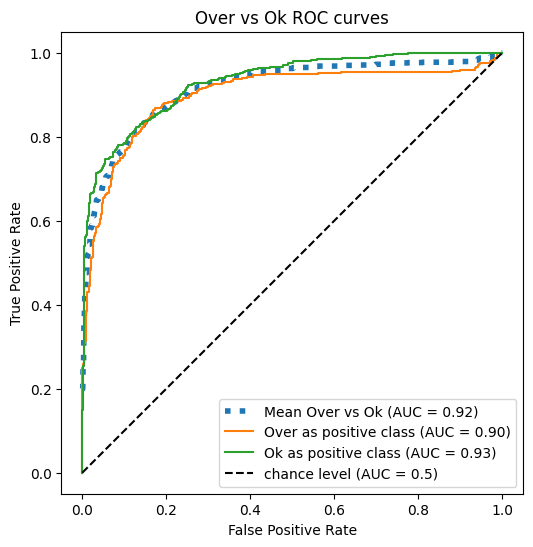

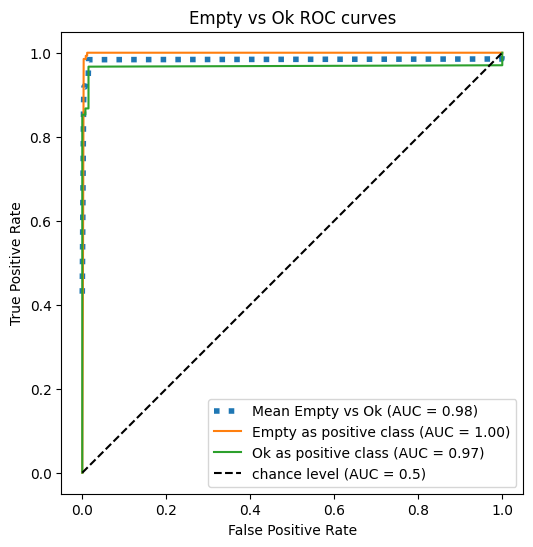

Macro-averaged One-vs-One ROC AUC score:
0.97


In [23]:
from sklearn.metrics import roc_curve, auc

pair_scores = []
mean_tpr = dict()
fpr_grid = np.linspace(0.0, 1.0, 1000)

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_true_val == label_a
    b_mask = y_true_val == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, yscore_val[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, yscore_val[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {class_dict[label_a]} vs {class_dict[label_b]} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        yscore_val[ab_mask, idx_a],
        ax=ax,
        name=f"{class_dict[label_a]} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        yscore_val[ab_mask, idx_b],
        ax=ax,
        name=f"{class_dict[label_b]} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{classes[idx_a]} vs {class_dict[label_b]} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")